## Table of Contents:

### 01. Importing Libraries and Data
### 02. Cleaning and wrangling time-series data 
### 03. Time-series analysis: decomposition
### 04. Testing for stationarity
### 05. Stationarizing the data

## 01. Importing Libraries and Data

In [276]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # 
import os
import warnings 
from datetime import datetime
warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [278]:
# Configure API key 
nasdaqdatalink.ApiConfig.api_key = '2fiojVwroXHcMhLQVpc_'

In [280]:
# Importing the data

data = nasdaqdatalink.get_table("QDL/JODI")

In [281]:
data.head()

,energy,code,country,date,value,notes
None,,,,,,
0,OIL,TPSDKT,ZAF,2024-07-31,0.0000,3
1,OIL,TPSDKT,ZAF,2024-06-30,0.0000,3
2,OIL,TPSDKT,ZAF,2024-05-31,0.0000,3
3,OIL,TPSDKT,ZAF,2024-04-30,0.0000,3
4,OIL,TPSDKT,ZAF,2024-03-31,0.0000,3


In [284]:
data.shape

(10000, 6)

## 02. Cleaning and Wrangling time-series data 

In [287]:
#checking for missing values 

In [289]:
data.isnull().sum()

energy        0
code          0
country       0
date          0
value      3108
notes         0
dtype: int64

In [291]:
#removing missing values since they make up less than 5% of dataset

In [293]:
df_clean = data[data['value'].isnull() == False]

In [295]:
#checking to see that the missing values have been removed
df_clean.isnull().sum()

energy     0
code       0
country    0
date       0
value      0
notes      0
dtype: int64

In [297]:
#checking to see if there are any duplicates
df_dups = df_clean[df_clean.duplicated()]

In [299]:
df_dups

,energy,code,country,date,value,notes
None,,,,,,


In [301]:
#no duplicates 

In [303]:
#checking for mixed-type columns
for col in df_clean.columns.tolist():
  weird = (df_clean[[col]].map(type) != df_clean[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df_clean[weird]) > 0:
    print (col)

In [305]:
#no mixed-type columns 

In [307]:
columns = ["date", "value"]

In [309]:
#making a new dataframe with just "date" and "value"
df_JODI = df_clean[columns]

In [311]:
df_JODI.head()

,date,value
None,,
0,2024-07-31,0.0000
1,2024-06-30,0.0000
2,2024-05-31,0.0000
3,2024-04-30,0.0000
4,2024-03-31,0.0000


In [313]:
#setting the date as the index 

In [315]:
df_JODI['datetime'] = pd.to_datetime(df_JODI['date']) # Creating a datetime column from "date"
df_JODI = df_JODI.set_index('datetime') # Setting the datetime as the index of the dataframe
df_JODI.drop(['date'], axis=1, inplace=True) # Dropping the "date" column
df_JODI.head()

,value
datetime,
2024-07-31,0.0000
2024-06-30,0.0000
2024-05-31,0.0000
2024-04-30,0.0000
2024-03-31,0.0000


In [317]:
#getting the sum of values grouped by datetime
df_JODI.groupby('datetime').agg({'value': ['sum']})

,value
,sum
datetime,
2009-01-31,-75.00000-17.00000.00001070.00000.00000-169.00...
2009-02-28,-510.000005.00000.00001422.00000.0000076.00000...
2009-03-31,30.00000-13.00000.00002216.00000.00000-125.000...
2009-04-30,-37.00000-32.000002035.00000.00000-30.00000.00...
2009-05-31,33.00000-3.00000.00002422.00000.00000-119.0000...
...,...
2024-04-30,0.00000.00000.0000-13.00008635.00000.0000-31.0...
2024-05-31,0.00000.00000.0000-33.0000-3335.00000.000033.0...


In [319]:
#checking 'value' datatype
df_JODI['value'].dtype

dtype('O')

In [321]:
#changing 'value' to float 
df_JODI['value'] = df_JODI['value'].astype('float64')

In [323]:
#getting the mean of values grouped by datetime
df_JODI.groupby('datetime').agg({'value': ['sum']})

,value
,sum
datetime,
2009-01-31,577.0
2009-02-28,542.0
2009-03-31,2095.0
2009-04-30,1483.0
2009-05-31,2264.0
...,...
2024-04-30,11571.0
2024-05-31,-1456.0


In [325]:
df_JODI_grouped = df_JODI.groupby('datetime').agg({'value': ['sum']})

In [327]:
df_JODI_grouped

,value
,sum
datetime,
2009-01-31,577.0
2009-02-28,542.0
2009-03-31,2095.0
2009-04-30,1483.0
2009-05-31,2264.0
...,...
2024-04-30,11571.0
2024-05-31,-1456.0


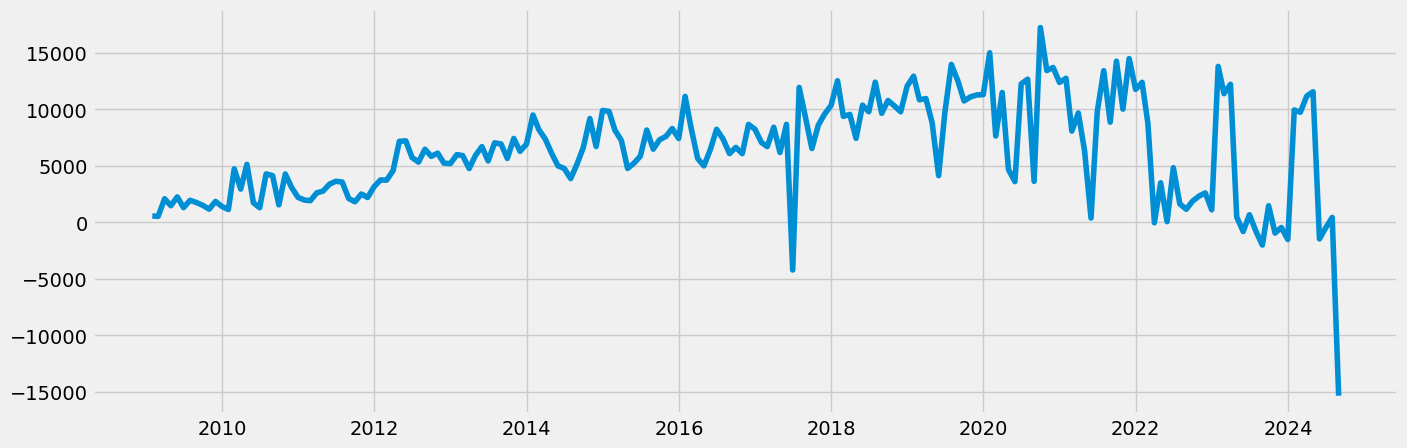

In [329]:
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df_JODI_grouped)

## 03. Time-series analysis: decomposition

In [332]:
# Decomposing the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_JODI_grouped, model='additive')

In [334]:
from pylab import rcParams # Defining a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

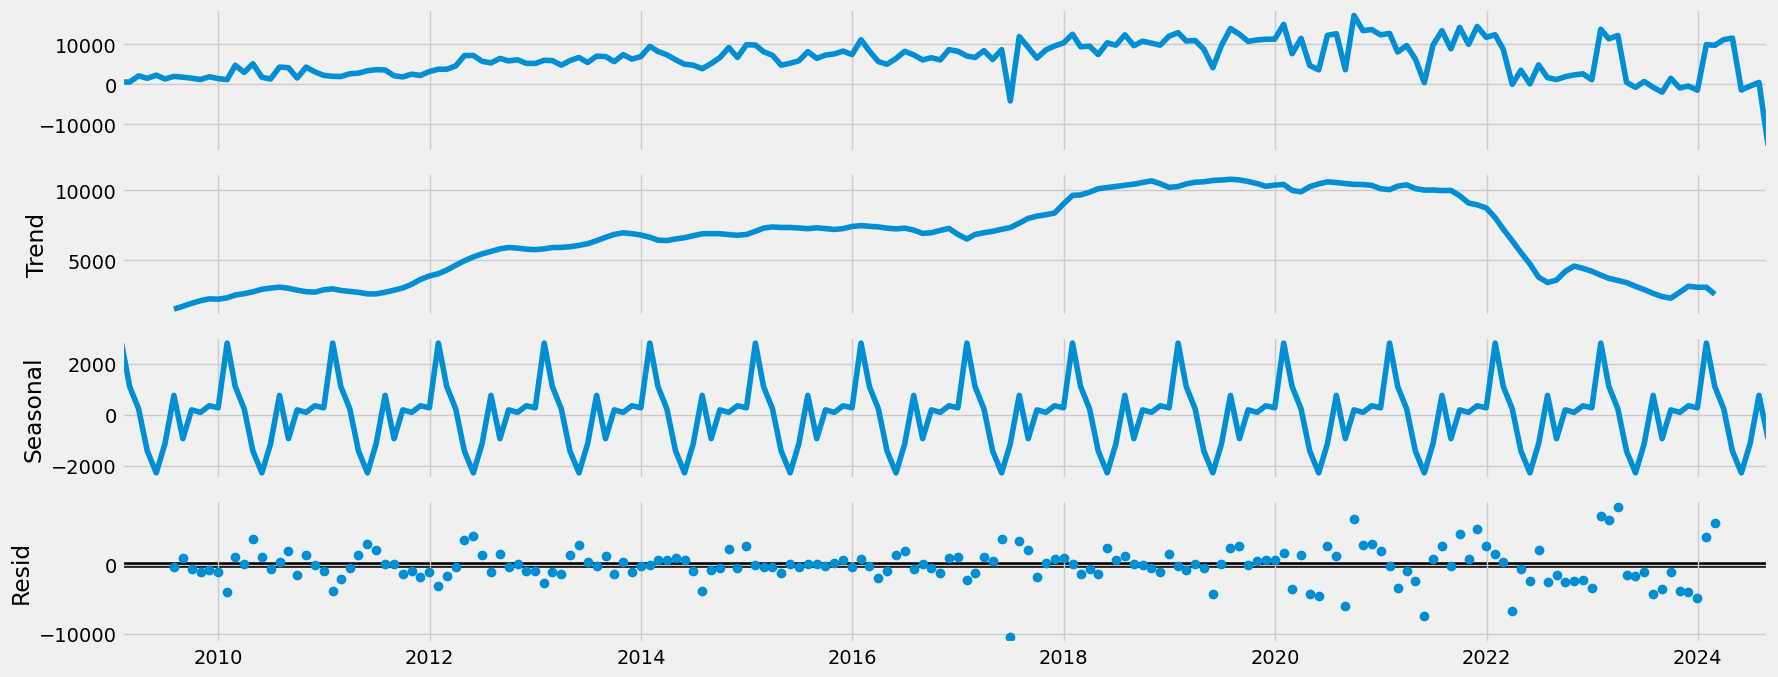

In [336]:
# Plotting the separate components
decomposition.plot()
plt.show()

#### Observations:

There is an upward trend until about 2019, after which there is a downward trend.  There is strong seasonality.  The value is at its highest around February and then drops drastically until about July.  There is another peak in August.

There isn't much unexplained noise until 2020.  This is probably due to the pandemic and resulting changes in oil demand.   

Given the presence of trend and seasonality, I would say that this data is non-stationary. 

## 04. Testing for stationarity

In [341]:
from statsmodels.tsa.stattools import adfuller # Importing the adfuller() function

def dickey_fuller(timeseries): # Defining the function
    # Performing the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Applying the test using the function on the time series
dickey_fuller(df_JODI_grouped['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.829772
p-value                          0.810220
Number of Lags Used             11.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


Null-hypothesis: There is a unit root.  
Alternate hypothesis: There is no unit root.

The test statistic is larger than all the critical values, which means we cannot reject the null hypothesis.  This means that there is a unit root and that the data is non-stationary.  Also, the p-value is higher than 0.05, which means the test result in non-significant.

## 05. Stationarizing the data

In [345]:
data_diff = df_JODI_grouped - df_JODI_grouped.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [347]:
data_diff.dropna(inplace = True) # Removing the missing values that came about as a result of the differencing in order to be able to run the Dickey-Fuller test.

In [349]:
data_diff.head()

,value
,sum
datetime,
2009-02-28,-35.0
2009-03-31,1553.0
2009-04-30,-612.0
2009-05-31,781.0
2009-06-30,-952.0


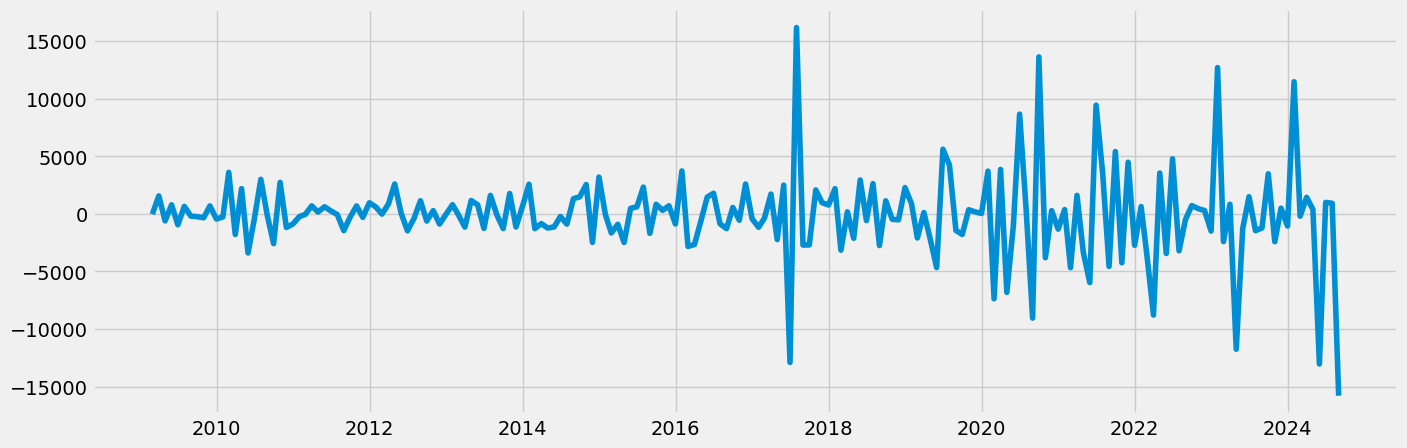

In [351]:
# Checking what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [353]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.623829e+00
p-value                        1.681220e-16
Number of Lags Used            1.000000e+01
Number of Observations Used    1.760000e+02
Critical Value (1%)           -3.468062e+00
Critical Value (5%)           -2.878106e+00
Critical Value (10%)          -2.575602e+00
dtype: float64


The test statistic is much smaller than all three critical values and the p value is much smaller than 0.05.  This means we can reject the null-hypothesis and furthermore, consider this data stationary. 

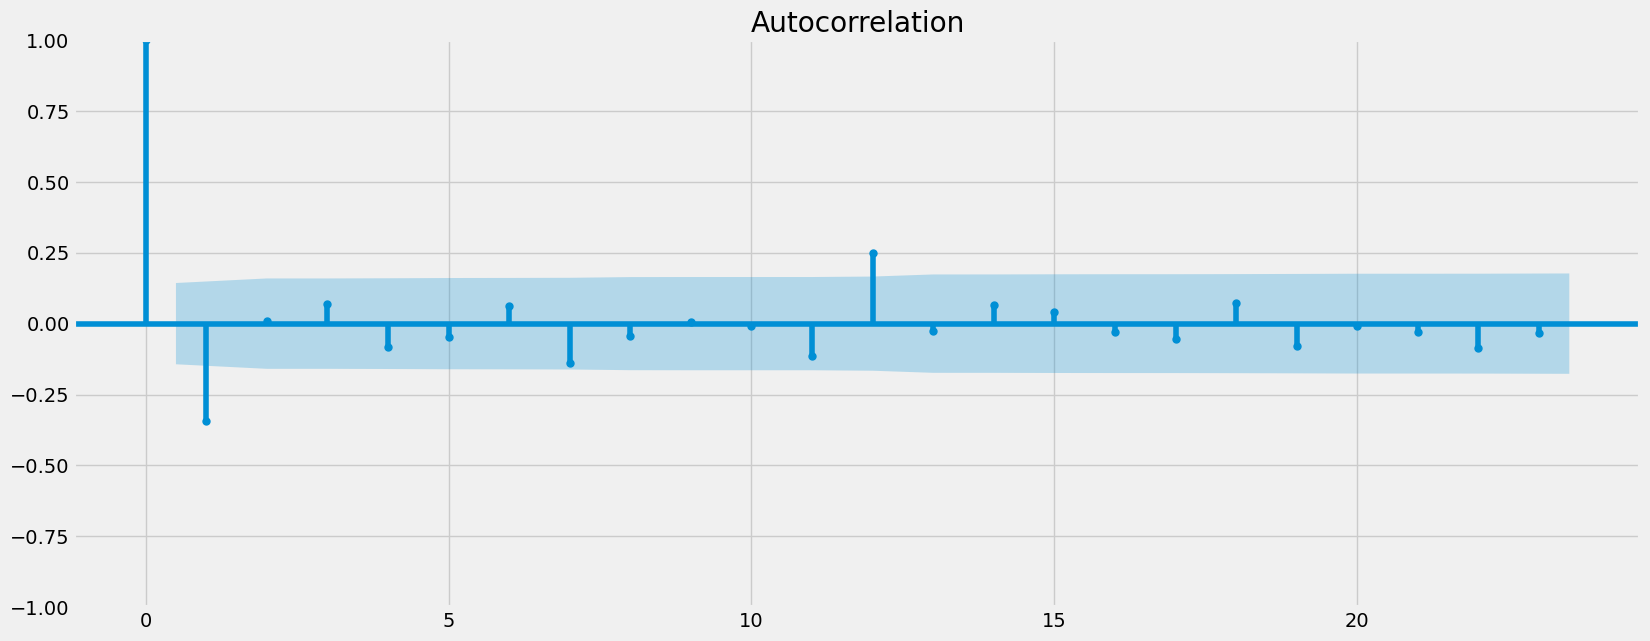

In [235]:
# Checking out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff)
plt.show()

There are only 3 significant lags, which means that although stationarity isn't perfect, no additional round of differencing is required.